In [8]:
import torch
import torch.nn as nn

In [9]:
# This UNET-style prediction model was originally included as part of the Score-based generative modelling tutorial 
# by Yang Song et al: https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [10]:
# ExponentialMovingAverage implementation as used in pytorch vision
# https://github.com/pytorch/vision/blob/main/references/classification/utils.py#L159

# BSD 3-Clause License

# Copyright (c) Soumith Chintala 2016, 
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# * Redistributions of source code must retain the above copyright notice, this
#   list of conditions and the following disclaimer.

# * Redistributions in binary form must reproduce the above copyright notice,
#   this list of conditions and the following disclaimer in the documentation
#   and/or other materials provided with the distribution.

# * Neither the name of the copyright holder nor the names of its
#   contributors may be used to endorse or promote products derived from
#   this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
    
class ExponentialMovingAverage(torch.optim.swa_utils.AveragedModel):
    """Maintains moving averages of model parameters using an exponential decay.
    ``ema_avg = decay * avg_model_param + (1 - decay) * model_param``
    `torch.optim.swa_utils.AveragedModel <https://pytorch.org/docs/stable/optim.html#custom-averaging-strategies>`_
    is used to compute the EMA.
    """

    def __init__(self, model, decay, device="cpu"):
        def ema_avg(avg_model_param, model_param, num_averaged):
            return decay * avg_model_param + (1 - decay) * model_param

        super().__init__(model, device, ema_avg, use_buffers=True)

Training:   1%|          | 234/23500 [00:11<18:40, 20.76it/s, epoch=1/100, loss=⠀      0.1235, lr=9.77E-04]

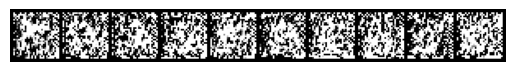

Training:   2%|▏         | 469/23500 [00:24<18:28, 20.77it/s, epoch=2/100, loss=⠀      0.1096, lr=9.54E-04]  

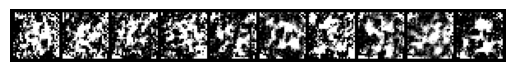

Training:   3%|▎         | 704/23500 [00:37<17:45, 21.40it/s, epoch=3/100, loss=⠀      0.0877, lr=9.32E-04]  

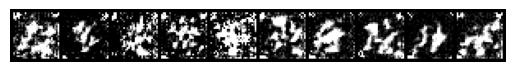

Training:   4%|▍         | 939/23500 [00:50<17:36, 21.35it/s, epoch=4/100, loss=⠀      0.0775, lr=9.10E-04]  

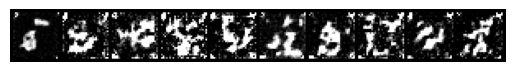

Training:   5%|▌         | 1175/23500 [01:04<16:05, 23.11it/s, epoch=5/100, loss=⠀      0.0633, lr=8.89E-04] 

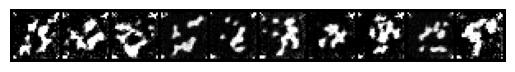

Training:   6%|▌         | 1409/23500 [01:18<18:56, 19.44it/s, epoch=6/100, loss=⠀      0.0520, lr=8.68E-04]  

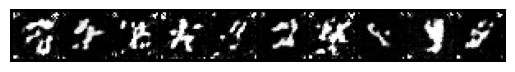

Training:   7%|▋         | 1644/23500 [01:31<17:00, 21.41it/s, epoch=7/100, loss=⠀      0.0493, lr=8.48E-04]  

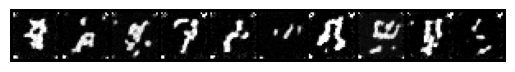

Training:   8%|▊         | 1880/23500 [01:45<18:35, 19.37it/s, epoch=8/100, loss=⠀      0.0508, lr=8.29E-04]  

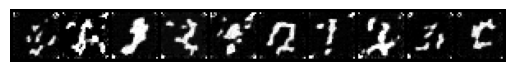

Training:   9%|▉         | 2114/23500 [01:58<16:53, 21.10it/s, epoch=9/100, loss=⠀      0.0664, lr=8.09E-04]  

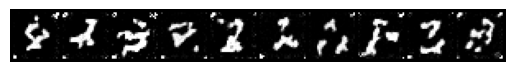

Training:  10%|█         | 2350/23500 [02:12<16:14, 21.70it/s, epoch=10/100, loss=⠀      0.0467, lr=7.91E-04]  

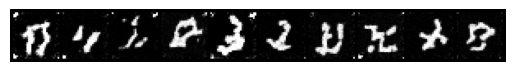

Training:  11%|█         | 2585/23500 [02:25<16:48, 20.73it/s, epoch=11/100, loss=⠀      0.0470, lr=7.72E-04]  

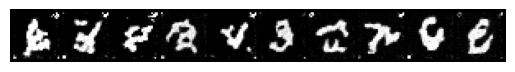

Training:  12%|█▏        | 2819/23500 [02:39<16:37, 20.74it/s, epoch=12/100, loss=⠀      0.0485, lr=7.54E-04]  

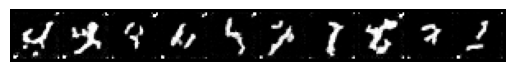

Training:  13%|█▎        | 3054/23500 [02:53<16:38, 20.47it/s, epoch=13/100, loss=⠀      0.0617, lr=7.37E-04]  

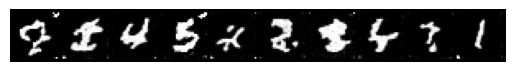

Training:  14%|█▍        | 3290/23500 [03:06<15:44, 21.41it/s, epoch=14/100, loss=⠀      0.0431, lr=7.20E-04]  

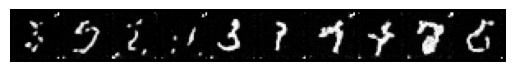

Training:  15%|█▍        | 3524/23500 [03:20<15:35, 21.36it/s, epoch=15/100, loss=⠀      0.0491, lr=7.03E-04]  

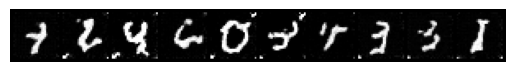

Training:  16%|█▌        | 3759/23500 [03:34<15:22, 21.39it/s, epoch=16/100, loss=⠀      0.0475, lr=6.87E-04]  

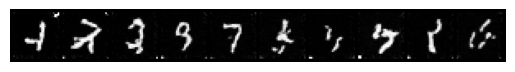

Training:  17%|█▋        | 3994/23500 [03:47<15:40, 20.74it/s, epoch=17/100, loss=⠀      0.0500, lr=6.71E-04]  

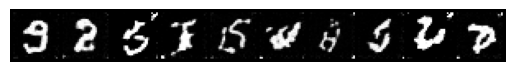

Training:  18%|█▊        | 4230/23500 [04:00<13:50, 23.19it/s, epoch=18/100, loss=⠀      0.0379, lr=6.55E-04]  

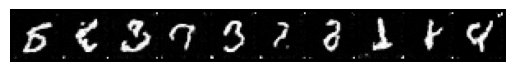

Training:  19%|█▉        | 4464/23500 [04:14<15:40, 20.24it/s, epoch=19/100, loss=⠀      0.0481, lr=6.40E-04]  

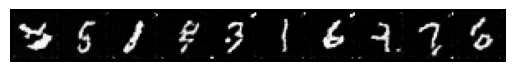

Training:  20%|██        | 4700/23500 [04:28<14:42, 21.31it/s, epoch=20/100, loss=⠀      0.0405, lr=6.25E-04]  

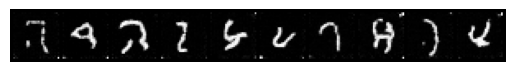

Training:  21%|██        | 4934/23500 [04:41<15:08, 20.43it/s, epoch=21/100, loss=⠀      0.0472, lr=6.10E-04]  

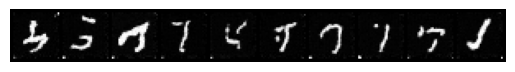

Training:  22%|██▏       | 5169/23500 [04:55<14:10, 21.55it/s, epoch=22/100, loss=⠀      0.0419, lr=5.96E-04]  

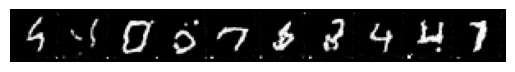

Training:  23%|██▎       | 5405/23500 [05:08<13:43, 21.98it/s, epoch=23/100, loss=⠀      0.0323, lr=5.82E-04]  

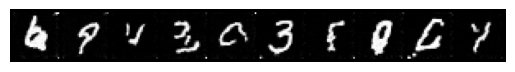

Training:  24%|██▍       | 5640/23500 [05:22<14:02, 21.19it/s, epoch=24/100, loss=⠀      0.0330, lr=5.69E-04]  

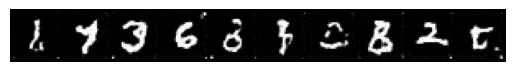

Training:  25%|██▍       | 5874/23500 [05:35<13:58, 21.03it/s, epoch=25/100, loss=⠀      0.0223, lr=5.56E-04]  

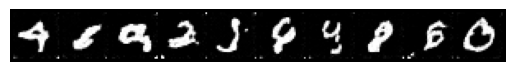

Training:  26%|██▌       | 6109/23500 [05:49<14:13, 20.38it/s, epoch=26/100, loss=⠀      0.0328, lr=5.43E-04]  

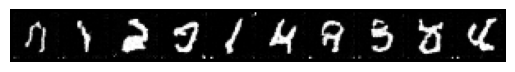

Training:  27%|██▋       | 6345/23500 [06:03<13:23, 21.35it/s, epoch=27/100, loss=⠀      0.0330, lr=5.30E-04]  

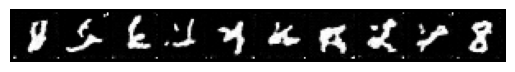

Training:  28%|██▊       | 6579/23500 [06:16<13:03, 21.60it/s, epoch=28/100, loss=⠀      0.0346, lr=5.18E-04]  

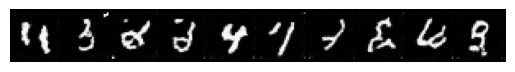

Training:  29%|██▉       | 6815/23500 [06:29<12:40, 21.93it/s, epoch=29/100, loss=⠀      0.0301, lr=5.06E-04]  

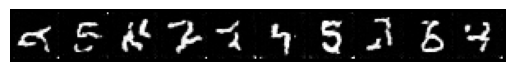

Training:  30%|██▉       | 7049/23500 [06:43<12:22, 22.17it/s, epoch=30/100, loss=⠀      0.0332, lr=4.94E-04]  

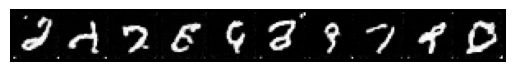

Training:  31%|███       | 7284/23500 [06:56<12:47, 21.13it/s, epoch=31/100, loss=⠀      0.0316, lr=4.83E-04]  

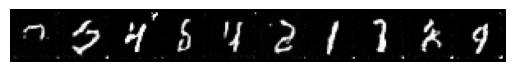

Training:  32%|███▏      | 7519/23500 [07:09<12:45, 20.87it/s, epoch=32/100, loss=⠀      0.0441, lr=4.71E-04]  

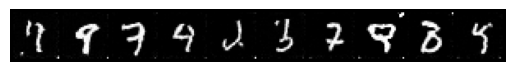

Training:  33%|███▎      | 7754/23500 [07:23<12:20, 21.26it/s, epoch=33/100, loss=⠀      0.0337, lr=4.60E-04]  

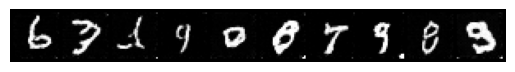

Training:  34%|███▍      | 7989/23500 [07:36<12:03, 21.43it/s, epoch=34/100, loss=⠀      0.0311, lr=4.50E-04]  

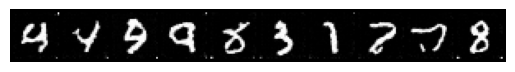

Training:  35%|███▌      | 8225/23500 [07:49<12:06, 21.02it/s, epoch=35/100, loss=⠀      0.0409, lr=4.39E-04]  

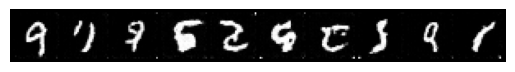

Training:  36%|███▌      | 8459/23500 [08:03<11:41, 21.43it/s, epoch=36/100, loss=⠀      0.0377, lr=4.29E-04]  

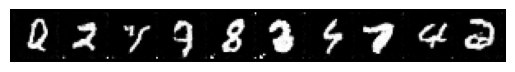

Training:  37%|███▋      | 8694/23500 [08:16<11:33, 21.35it/s, epoch=37/100, loss=⠀      0.0295, lr=4.19E-04]  

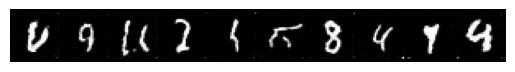

Training:  38%|███▊      | 8929/23500 [08:29<11:42, 20.75it/s, epoch=38/100, loss=⠀      0.0301, lr=4.09E-04]  

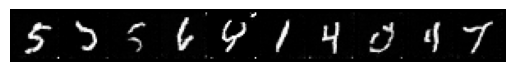

Training:  39%|███▉      | 9164/23500 [08:42<11:05, 21.55it/s, epoch=39/100, loss=⠀      0.0337, lr=4.00E-04]  

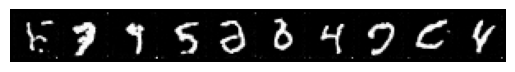

Training:  40%|████      | 9400/23500 [08:56<10:26, 22.52it/s, epoch=40/100, loss=⠀      0.0284, lr=3.91E-04]  

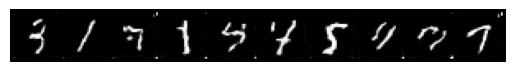

Training:  41%|████      | 9634/23500 [09:09<10:28, 22.05it/s, epoch=41/100, loss=⠀      0.0395, lr=3.82E-04]  

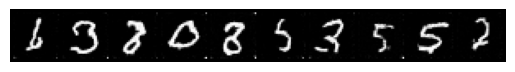

Training:  42%|████▏     | 9869/23500 [09:22<10:26, 21.77it/s, epoch=42/100, loss=⠀      0.0355, lr=3.73E-04]  

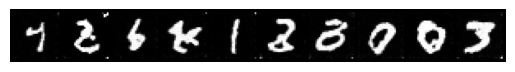

Training:  43%|████▎     | 10104/23500 [09:35<10:20, 21.60it/s, epoch=43/100, loss=⠀      0.0297, lr=3.64E-04] 

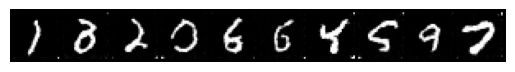

Training:  44%|████▍     | 10339/23500 [09:49<10:15, 21.40it/s, epoch=44/100, loss=⠀      0.0337, lr=3.56E-04]  

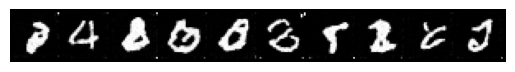

Training:  45%|████▌     | 10575/23500 [10:02<09:36, 22.40it/s, epoch=45/100, loss=⠀      0.0273, lr=3.47E-04]

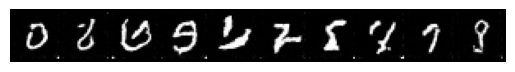

Training:  46%|████▌     | 10809/23500 [10:16<10:21, 20.42it/s, epoch=46/100, loss=⠀      0.0321, lr=3.39E-04]

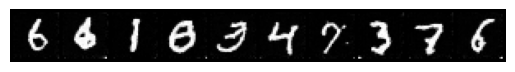

Training:  47%|████▋     | 11044/23500 [10:29<09:50, 21.08it/s, epoch=47/100, loss=⠀      0.0329, lr=3.31E-04]

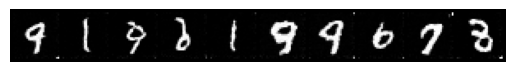

Training:  48%|████▊     | 11279/23500 [10:42<09:26, 21.56it/s, epoch=48/100, loss=⠀      0.0350, lr=3.24E-04]

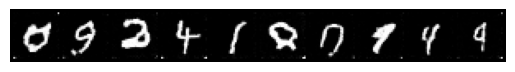

Training:  49%|████▉     | 11514/23500 [10:56<09:11, 21.71it/s, epoch=49/100, loss=⠀      0.0317, lr=3.16E-04]

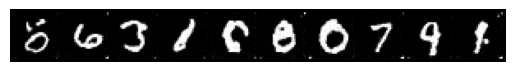

Training:  50%|█████     | 11750/23500 [11:09<09:03, 21.61it/s, epoch=50/100, loss=⠀      0.0273, lr=3.09E-04]

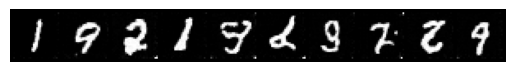

Training:  51%|█████     | 11984/23500 [11:22<09:11, 20.87it/s, epoch=51/100, loss=⠀      0.0319, lr=3.02E-04]

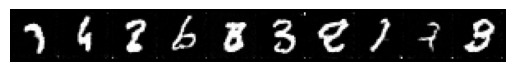

Training:  52%|█████▏    | 12219/23500 [11:36<09:06, 20.64it/s, epoch=52/100, loss=⠀      0.0284, lr=2.95E-04]

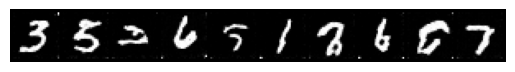

Training:  53%|█████▎    | 12454/23500 [11:50<08:49, 20.85it/s, epoch=53/100, loss=⠀      0.0356, lr=2.88E-04]

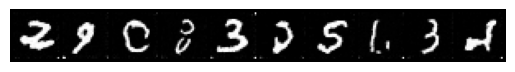

Training:  54%|█████▍    | 12689/23500 [12:03<08:19, 21.62it/s, epoch=54/100, loss=⠀      0.0248, lr=2.81E-04]

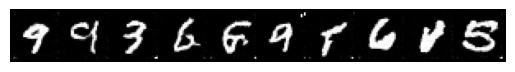

Training:  55%|█████▍    | 12924/23500 [12:17<08:17, 21.24it/s, epoch=55/100, loss=⠀      0.0463, lr=2.75E-04]

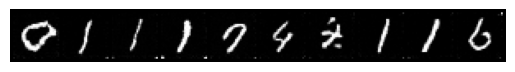

Training:  56%|█████▌    | 13159/23500 [12:30<08:01, 21.50it/s, epoch=56/100, loss=⠀      0.0300, lr=2.68E-04]

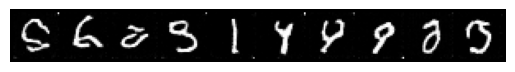

Training:  57%|█████▋    | 13394/23500 [12:44<07:54, 21.28it/s, epoch=57/100, loss=⠀      0.0279, lr=2.62E-04]

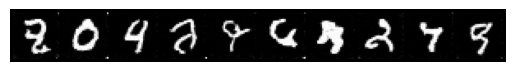

Training:  58%|█████▊    | 13629/23500 [12:57<07:36, 21.63it/s, epoch=58/100, loss=⠀      0.0327, lr=2.56E-04]

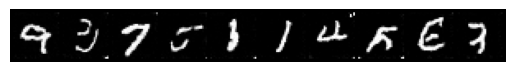

Training:  59%|█████▉    | 13865/23500 [13:11<08:17, 19.37it/s, epoch=59/100, loss=⠀      0.0316, lr=2.50E-04]

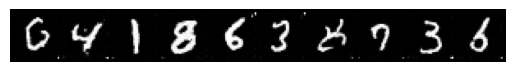

Training:  60%|█████▉    | 14099/23500 [13:24<07:18, 21.46it/s, epoch=60/100, loss=⠀      0.0297, lr=2.44E-04]

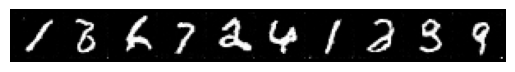

Training:  61%|██████    | 14334/23500 [13:38<07:44, 19.72it/s, epoch=61/100, loss=⠀      0.0262, lr=2.38E-04]

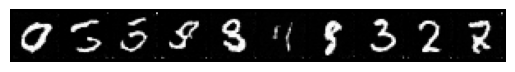

Training:  62%|██████▏   | 14570/23500 [13:51<06:38, 22.41it/s, epoch=62/100, loss=⠀      0.0300, lr=2.33E-04]

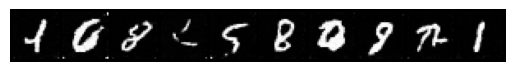

Training:  63%|██████▎   | 14804/23500 [14:05<07:21, 19.68it/s, epoch=63/100, loss=⠀      0.0389, lr=2.28E-04]

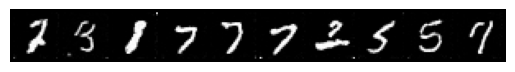

Training:  64%|██████▍   | 15039/23500 [14:18<06:43, 20.95it/s, epoch=64/100, loss=⠀      0.0336, lr=2.22E-04]

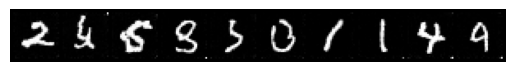

Training:  65%|██████▌   | 15275/23500 [14:31<06:03, 22.64it/s, epoch=65/100, loss=⠀      0.0269, lr=2.17E-04]

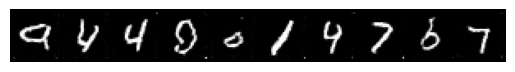

Training:  66%|██████▌   | 15509/23500 [14:44<06:22, 20.91it/s, epoch=66/100, loss=⠀      0.0300, lr=2.12E-04]

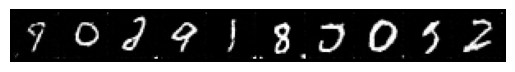

Training:  67%|██████▋   | 15745/23500 [14:58<05:58, 21.62it/s, epoch=67/100, loss=⠀      0.0276, lr=2.07E-04]

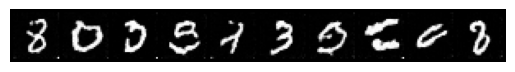

Training:  68%|██████▊   | 15980/23500 [15:12<05:43, 21.87it/s, epoch=68/100, loss=⠀      0.0320, lr=2.02E-04]

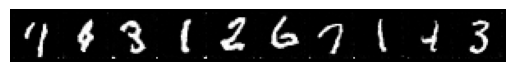

Training:  69%|██████▉   | 16214/23500 [15:25<05:52, 20.68it/s, epoch=69/100, loss=⠀      0.0306, lr=1.98E-04]

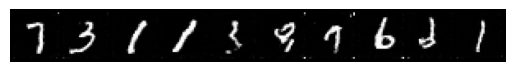

Training:  70%|███████   | 16450/23500 [15:39<05:28, 21.47it/s, epoch=70/100, loss=⠀      0.0246, lr=1.93E-04]

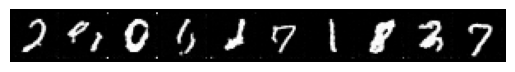

Training:  71%|███████   | 16684/23500 [15:52<05:40, 20.04it/s, epoch=71/100, loss=⠀      0.0239, lr=1.89E-04]

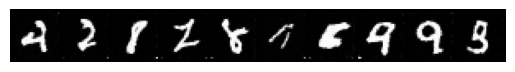

Training:  72%|███████▏  | 16919/23500 [16:06<05:31, 19.84it/s, epoch=72/100, loss=⠀      0.0299, lr=1.84E-04]

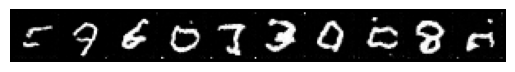

Training:  73%|███████▎  | 17154/23500 [16:19<05:11, 20.36it/s, epoch=73/100, loss=⠀      0.0273, lr=1.80E-04]

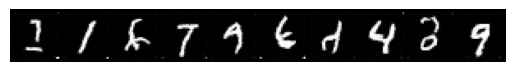

Training:  74%|███████▍  | 17390/23500 [16:33<04:33, 22.38it/s, epoch=74/100, loss=⠀      0.0330, lr=1.76E-04]

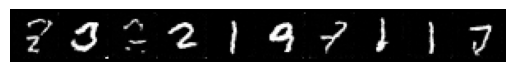

Training:  75%|███████▍  | 17624/23500 [16:46<04:43, 20.72it/s, epoch=75/100, loss=⠀      0.0272, lr=1.72E-04]

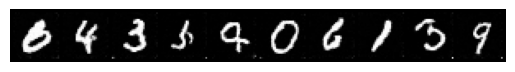

Training:  76%|███████▌  | 17859/23500 [17:00<04:28, 21.03it/s, epoch=76/100, loss=⠀      0.0292, lr=1.68E-04]

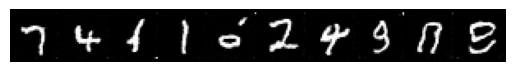

Training:  77%|███████▋  | 18094/23500 [17:13<04:19, 20.82it/s, epoch=77/100, loss=⠀      0.0403, lr=1.64E-04]

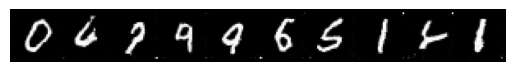

Training:  78%|███████▊  | 18329/23500 [17:27<04:08, 20.85it/s, epoch=78/100, loss=⠀      0.0250, lr=1.60E-04]

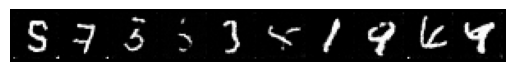

Training:  79%|███████▉  | 18564/23500 [17:40<03:40, 22.39it/s, epoch=79/100, loss=⠀      0.0281, lr=1.56E-04]

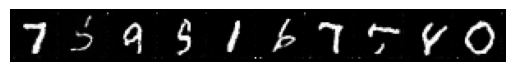

Training:  80%|████████  | 18800/23500 [17:53<03:28, 22.54it/s, epoch=80/100, loss=⠀      0.0272, lr=1.53E-04]

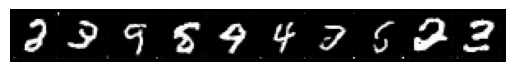

Training:  81%|████████  | 19034/23500 [18:06<03:30, 21.25it/s, epoch=81/100, loss=⠀      0.0287, lr=1.49E-04]

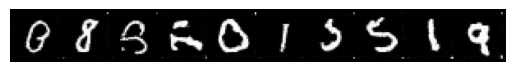

Training:  82%|████████▏ | 19270/23500 [18:19<03:10, 22.20it/s, epoch=82/100, loss=⠀      0.0342, lr=1.46E-04]

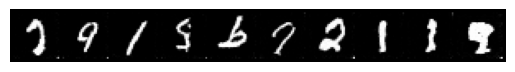

Training:  83%|████████▎ | 19504/23500 [18:32<03:05, 21.52it/s, epoch=83/100, loss=⠀      0.0261, lr=1.42E-04]

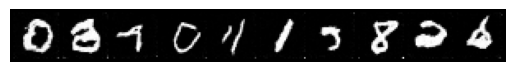

Training:  84%|████████▍ | 19739/23500 [18:45<02:54, 21.61it/s, epoch=84/100, loss=⠀      0.0263, lr=1.39E-04]

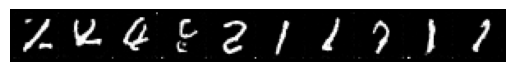

Training:  85%|████████▍ | 19974/23500 [18:58<02:41, 21.85it/s, epoch=85/100, loss=⠀      0.0320, lr=1.36E-04]

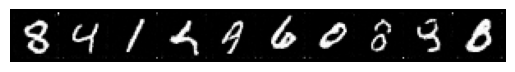

Training:  86%|████████▌ | 20209/23500 [19:12<02:32, 21.64it/s, epoch=86/100, loss=⠀      0.0324, lr=1.33E-04]

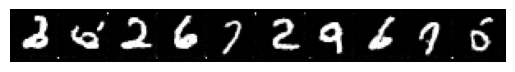

Training:  87%|████████▋ | 20444/23500 [19:25<02:30, 20.32it/s, epoch=87/100, loss=⠀      0.0286, lr=1.29E-04]

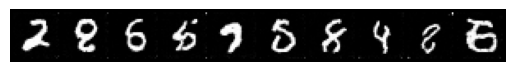

Training:  88%|████████▊ | 20680/23500 [19:39<02:05, 22.46it/s, epoch=88/100, loss=⠀      0.0275, lr=1.26E-04]

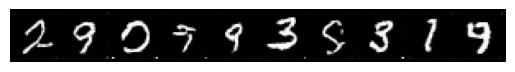

Training:  89%|████████▉ | 20914/23500 [19:52<02:01, 21.23it/s, epoch=89/100, loss=⠀      0.0230, lr=1.23E-04]

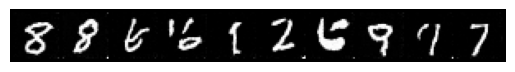

Training:  90%|█████████ | 21150/23500 [20:05<01:48, 21.72it/s, epoch=90/100, loss=⠀      0.0358, lr=1.21E-04]

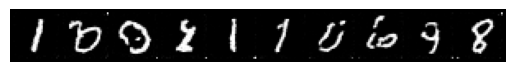

Training:  91%|█████████ | 21384/23500 [20:18<01:36, 21.94it/s, epoch=91/100, loss=⠀      0.0297, lr=1.18E-04]

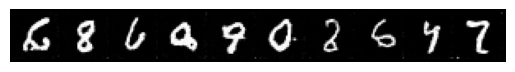

Training:  92%|█████████▏| 21619/23500 [20:31<01:29, 21.07it/s, epoch=92/100, loss=⠀      0.0339, lr=1.15E-04]

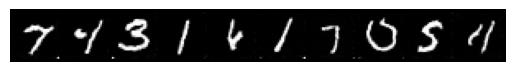

Training:  93%|█████████▎| 21855/23500 [20:45<01:13, 22.27it/s, epoch=93/100, loss=⠀      0.0219, lr=1.12E-04]

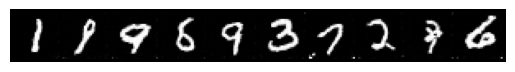

Training:  94%|█████████▍| 22089/23500 [20:58<01:05, 21.39it/s, epoch=94/100, loss=⠀      0.0278, lr=1.10E-04]

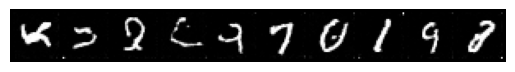

Training:  95%|█████████▌| 22325/23500 [21:11<00:51, 22.61it/s, epoch=95/100, loss=⠀      0.0318, lr=1.07E-04]

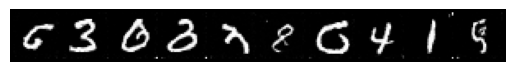

Training:  96%|█████████▌| 22559/23500 [21:24<00:43, 21.85it/s, epoch=96/100, loss=⠀      0.0297, lr=1.05E-04]

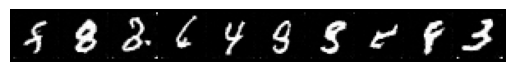

Training:  97%|█████████▋| 22794/23500 [21:37<00:32, 21.90it/s, epoch=97/100, loss=⠀      0.0332, lr=1.02E-04]

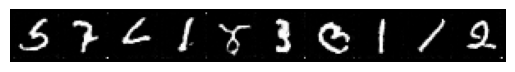

Training:  98%|█████████▊| 23029/23500 [21:50<00:21, 22.02it/s, epoch=98/100, loss=⠀      0.0213, lr=9.99E-05]

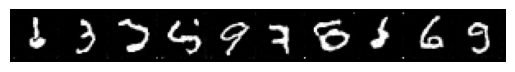

Training:  99%|█████████▉| 23265/23500 [22:03<00:10, 22.93it/s, epoch=99/100, loss=⠀      0.0316, lr=9.76E-05]

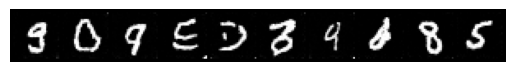

Training: 100%|█████████▉| 23499/23500 [22:16<00:00, 20.61it/s, epoch=100/100, loss=⠀      0.0271, lr=9.54E-05]

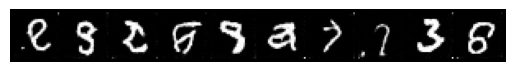

Training: 100%|██████████| 23500/23500 [22:18<00:00, 17.55it/s, epoch=100/100, loss=⠀      0.0271, lr=9.54E-05]


In [11]:
from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math

class DDPM(nn.Module):

    def __init__(self, network, T=100, beta_1=1e-4, beta_T=2e-2):
        """
        Initialize Denoising Diffusion Probabilistic Model

        Parameters
        ----------
        network: nn.Module
            The inner neural network used by the diffusion process. Typically a Unet.
        beta_1: float
            beta_t value at t=1 
        beta_T: [float]
            beta_t value at t=T (last step)
        T: int
            The number of diffusion steps.
        """
        
        super(DDPM, self).__init__()

        # Normalize time input before evaluating neural network
        # Reshape input into image format and normalize time value before sending it to network model
        self._network = network
        self.network = lambda x, t: (self._network(x.reshape(-1, 1, 28, 28), 
                                                   (t.squeeze()/T))
                                    ).reshape(-1, 28*28)

        # Total number of time steps
        self.T = T

        # Registering as buffers to ensure they get transferred to the GPU automatically
        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T+1))
        self.register_buffer("alpha", 1-self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))
        

    def forward_diffusion(self, x0, t, epsilon):
        '''
        q(x_t | x_0)
        Forward diffusion from an input datapoint x0 to an xt at timestep t, provided a N(0,1) noise sample epsilon. 
        Note that we can do this operation in a single step

        Parameters
        ----------
        x0: torch.tensor
            x value at t=0 (an input image)
        t: int
            step index 
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t
        ''' 

        mean = torch.sqrt(self.alpha_bar[t])*x0
        std = torch.sqrt(1 - self.alpha_bar[t])
        
        return mean + std*epsilon

    def reverse_diffusion(self, xt, t, epsilon):
        """
        p(x_{t-1} | x_t)
        Single step in the reverse direction, from x_t (at timestep t) to x_{t-1}, provided a N(0,1) noise sample epsilon.

        Parameters
        ----------
        xt: torch.tensor
            x value at step t
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t-1
        """

        mean =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*self.network(xt, t)) 
        std = torch.where(t>0, torch.sqrt(((1-self.alpha_bar[t-1]) / (1-self.alpha_bar[t]))*self.beta[t]), 0)
        
        return mean + std*epsilon

    
    @torch.no_grad()
    def sample(self, shape):
        """
        Sample from diffusion model (Algorithm 2 in Ho et al, 2020)

        Parameters
        ----------
        shape: tuple
            Specify shape of sampled output. For MNIST: (nsamples, 28*28)

        Returns
        -------
        torch.tensor
            sampled image            
        """
        
        # Sample xT: Gaussian noise
        xT = torch.randn(shape).to(self.beta.device)

        xt = xT
        for t in range(self.T, 0, -1):
            noise = torch.randn_like(xT) if t > 1 else 0
            t = torch.tensor(t).expand(xt.shape[0], 1).to(self.beta.device)            
            xt = self.reverse_diffusion(xt, t, noise)

        return xt

    
    def elbo_simple(self, x0):
        """
        ELBO training objective (Algorithm 1 in Ho et al, 2020)

        Parameters
        ----------
        x0: torch.tensor
            Input image

        Returns
        -------
        float
            ELBO value            
        """

        # Sample time step t
        t = torch.randint(1, self.T, (x0.shape[0],1)).to(x0.device)
        
        # Sample noise
        epsilon = torch.randn_like(x0)

        # TODO: Forward diffusion to produce image at step t
        xt = self.forward_diffusion(x0, t, epsilon)
        
        return -nn.MSELoss(reduction='mean')(epsilon, self.network(xt, t))

    
    def loss(self, x0):
        """
        Loss function. Just the negative of the ELBO.
        """
        return -self.elbo_simple(x0).mean()


def train(model, optimizer, scheduler, dataloader, epochs, device, ema=True, per_epoch_callback=None):
    """
    Training loop
    
    Parameters
    ----------
    model: nn.Module
        Pytorch model
    optimizer: optim.Optimizer
        Pytorch optimizer to be used for training
    scheduler: optim.LRScheduler
        Pytorch learning rate scheduler
    dataloader: utils.DataLoader
        Pytorch dataloader
    epochs: int
        Number of epochs to train
    device: torch.device
        Pytorch device specification
    ema: Boolean
        Whether to activate Exponential Model Averaging
    per_epoch_callback: function
        Called at the end of every epoch
    """

    # Setup progress bar
    total_steps = len(dataloader)*epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    if ema:
        ema_global_step_counter = 0
        ema_steps = 10
        ema_adjust = dataloader.batch_size * ema_steps / epochs
        ema_decay = 1.0 - 0.995
        ema_alpha = min(1.0, (1.0 - ema_decay) * ema_adjust)
        ema_model = ExponentialMovingAverage(model, device=device, decay=1.0 - ema_alpha)                
    
    for epoch in range(epochs):

        # Switch to train mode
        model.train()

        global_step_counter = 0
        for i, (x, _) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Update progress bar
            progress_bar.set_postfix(loss=f"⠀{loss.item():12.4f}", epoch=f"{epoch+1}/{epochs}", lr=f"{scheduler.get_last_lr()[0]:.2E}")
            progress_bar.update()

            if ema:
                ema_global_step_counter += 1
                if ema_global_step_counter%ema_steps==0:
                    ema_model.update_parameters(model)                
        
        if per_epoch_callback:
            per_epoch_callback(ema_model.module if ema else model)


# Parameters
T = 1000
learning_rate = 1e-3
epochs = 100
batch_size = 256


# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020, 
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, -1]
    transforms.Lambda(lambda x: x.flatten())
])

# Download and transform train dataset
dataloader_train = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=True, transform=transform),
                                                batch_size=batch_size,
                                                shuffle=True)

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Construct Unet
# The original ScoreNet expects a function with std for all the
# different noise levels, such that the output can be rescaled.
# Since we are predicting the noise (rather than the score), we
# ignore this rescaling and just set std=1 for all t.
mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)))

# Construct model
model = DDPM(mnist_unet, T=T).to(device)

# Construct optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Setup simple scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)


def reporter(model):
    """Callback function used for plotting images during training"""
    
    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        nsamples = 10
        samples = model.sample((nsamples,28*28)).cpu()
        
        # Map pixel values back from [-1,1] to [0,1]
        samples = (samples+1)/2 
        samples = samples.clamp(0.0, 1.0)

        # Plot in grid
        grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
        plt.gca().set_axis_off()
        plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
        plt.show()    

# Call training loop
train(model, optimizer, scheduler, dataloader_train, 
      epochs=epochs, device=device, ema=True, per_epoch_callback=reporter)


Sampling 2000 images from the full dataset for comparison...
Generating 16 new images...


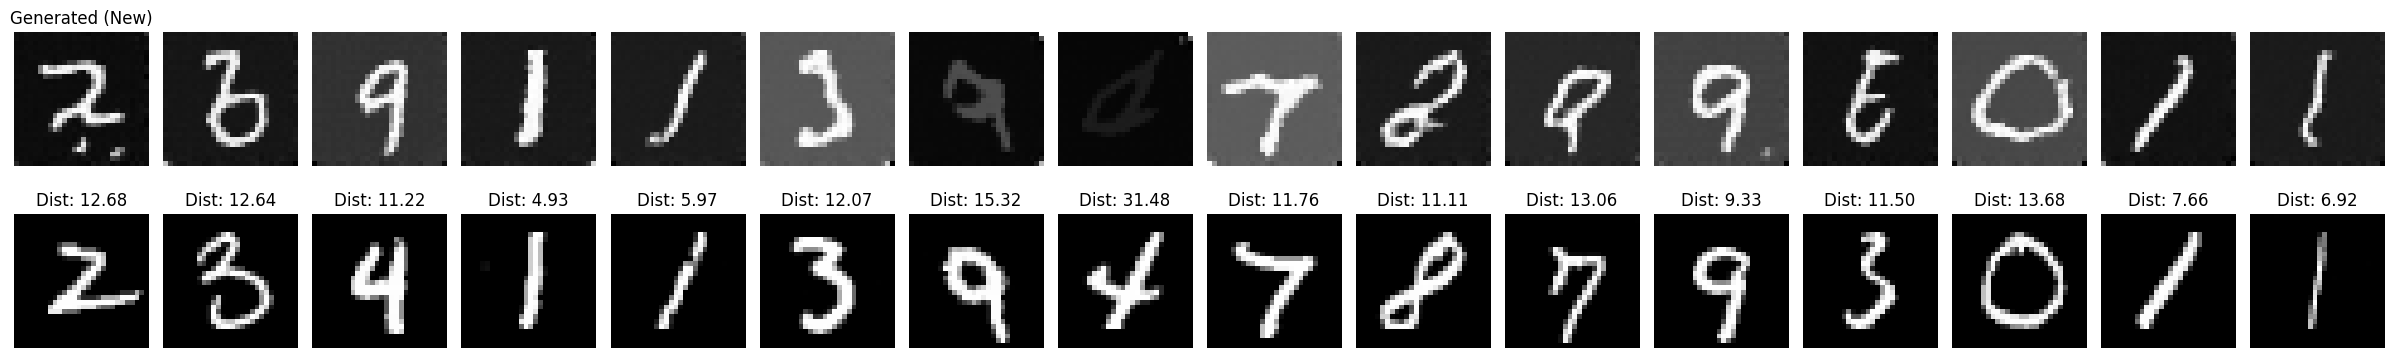

Average nearest neighbor distance: 11.9576
Normalized distance (per dimension): 0.4271
The model might be overfitting (distances are surprisingly small).
Potential memorization detected.
Generated images are too similar to training samples.


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import math

def check_generalization(model, full_train_dataset, num_samples=16, subset_size=2000, device='cuda'):
    """
    Generate images and find the nearest neighbor in a random subset of the full training set
    to verify generalization capabilities.
    """
    model.eval()

    # 1. Prepare training set data (Random Subset) for comparison
    # We sample a subset (e.g., 2000 images) to avoid OOM and speed up calculation
    print(f"Sampling {subset_size} images from the full dataset for comparison...")
    
    indices = torch.randperm(len(full_train_dataset))[:subset_size]
    train_subset_images = []
    
    # Retrieve items using the sampled indices
    for idx in indices:
        img, _ = full_train_dataset[idx]
        train_subset_images.append(img)
    
    train_images = torch.stack(train_subset_images).to(device) # Shape: [subset_size, 784]

    # 2. Let the model generate a batch of new images
    print(f"Generating {num_samples} new images...")
    with torch.no_grad():
        # Call the DDPM sample function
        generated_imgs = model.sample((num_samples, 28*28))

    # 3. Compute distance (L2 Distance)
    dists = torch.cdist(generated_imgs, train_images, p=2)

    # 4. Find nearest neighbor (the one with minimum distance)
    min_dists, min_indices = torch.min(dists, dim=1)

    # 5. Visualize comparison
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 1.5, 4))

    # Rescale data from [-1, 1] back to [0, 1] for display
    gen_imgs_display = (generated_imgs.cpu() + 1) / 2
    train_images_display = (train_images.cpu() + 1) / 2

    for i in range(num_samples):
        # Top row: Generated
        axes[0, i].imshow(gen_imgs_display[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        if i == 0: axes[0, i].set_title("Generated (New)")

        # Bottom row: Nearest Neighbor from Train Subset
        idx = min_indices[i].item()
        closest_img = train_images_display[idx]
        axes[1, i].imshow(closest_img.reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')

        axes[1, i].set_title(f"Dist: {min_dists[i].item():.2f}")
        if i == 0: axes[1, i].set_ylabel("Nearest Train")

    plt.tight_layout()
    plt.show()

    # 6. Analysis & Conclusion
    avg_dist = min_dists.mean().item()
    print(f"Average nearest neighbor distance: {avg_dist:.4f}")

    normalized_dist = avg_dist / math.sqrt(28*28)
    print(f"Normalized distance (per dimension): {normalized_dist:.4f}")
    
    # Updated thresholds logic for generalization check
    if avg_dist > 20.0: 
        print("The model exhibits good diversity (distances are large).")
    else:
        print("The model might be overfitting (distances are surprisingly small).")
        
    if normalized_dist > 0.7:
        print("Good generalization detected.")
        print("Generated images are distinct from training samples (creation, not copy).")
    else:
        print("Potential memorization detected.")
        print("Generated images are too similar to training samples.")

# Execute verification for Baseline
# subset_size=2000 is enough to be statistically significant
if 'model' in locals() and 'dataloader_train' in locals():
    check_generalization(model, dataloader_train.dataset, num_samples=16, subset_size=2000, device=device)
else:
    print("Please make sure 'model' and 'dataloader_train' are loaded from the solution notebook.")

[BASELINE] Preparing reference data...
[BASELINE] Generating 16 samples...

>>> Experiment Results (baseline) <<<
Average NND (L2): 11.0540
Normalized Dist:  0.3948
>> Verdict: Good Generalization - The model is creating novel images.


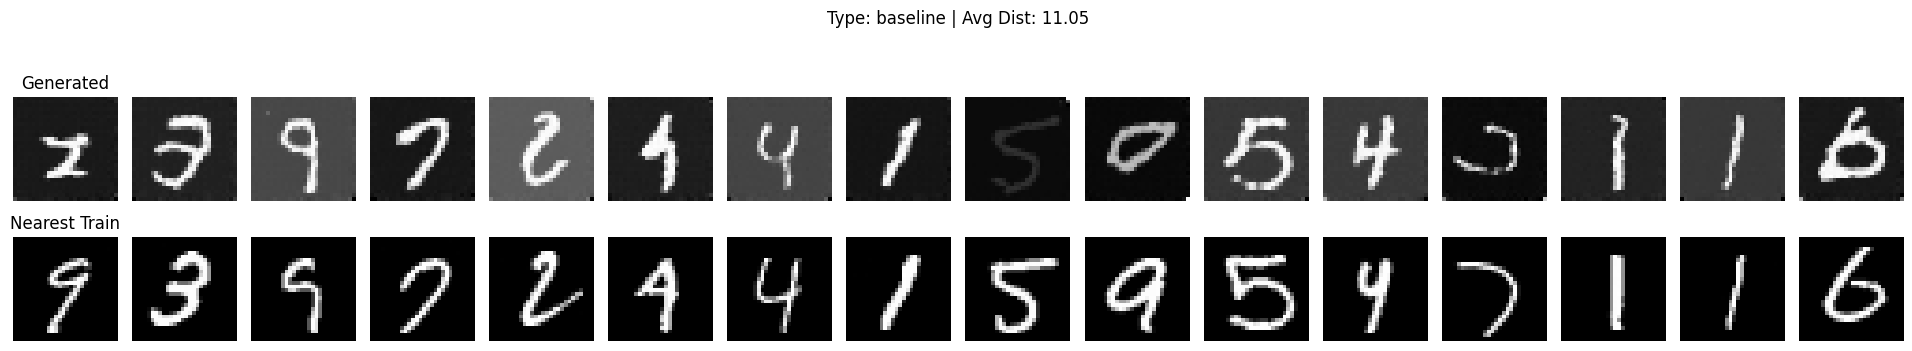

In [15]:
import torch
import matplotlib.pyplot as plt
import math

def evaluate_model_behavior(model, dataset, experiment_type="baseline", device='cuda'):
    """
    experiment_type: 
      - 'baseline': Randomly samples 2000 images as reference (checks for generalization).
      - 'memorization': Uses all 128 images as reference (checks for memorization).
    """
    model.eval()
    num_samples = 16
    
    # 1. Prepare Reference Data
    print(f"[{experiment_type.upper()}] Preparing reference data...")
    if experiment_type == "baseline":
        # Baseline: Randomly sample 2000 images to avoid OOM (Out Of Memory)
        subset_size = 2000
        # Use torch.randperm to generate random indices
        indices = torch.randperm(len(dataset))[:subset_size]
        # Collect images (assuming dataset returns (img, label))
        ref_images = torch.stack([dataset[i][0] for i in indices]).to(device)
    else:
        # Memorization: Use the full small dataset (128 images)
        ref_images = torch.stack([dataset[i][0] for i in range(len(dataset))]).to(device)

    # 2. Generate New Samples
    print(f"[{experiment_type.upper()}] Generating {num_samples} samples...")
    with torch.no_grad():
        generated_imgs = model.sample((num_samples, 28*28))

    # 3. Compute Nearest Neighbor Distances (L2)
    # dists shape: [num_samples, num_ref_images]
    dists = torch.cdist(generated_imgs, ref_images, p=2)
    min_dists, min_indices = torch.min(dists, dim=1)
    
    # 4. Compute Statistics
    avg_dist = min_dists.mean().item()
    norm_dist = avg_dist / math.sqrt(28*28) # Normalized distance
    
    print(f"\n>>> Experiment Results ({experiment_type}) <<<")
    print(f"Average NND (L2): {avg_dist:.4f}")
    print(f"Normalized Dist:  {norm_dist:.4f}")
    
    # 5. Automatic Conclusion
    if avg_dist < 5.0:
        print(">> Verdict: Strong Memorization - The model is copying training data.")
    elif avg_dist > 10.0:
        print(">> Verdict: Good Generalization - The model is creating novel images.")
    else:
        print(">> Verdict: Transition Phase")

    # 6. Visualization (Top: Generated, Bottom: Nearest Training Image)
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 1.2, 3.5))
    
    # Unnormalize images from [-1, 1] to [0, 1]
    gen_disp = (generated_imgs.cpu() + 1) / 2
    ref_disp = (ref_images.cpu() + 1) / 2
    
    for i in range(num_samples):
        # Display generated images
        axes[0, i].imshow(gen_disp[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        if i == 0: axes[0, i].set_title("Generated")
        
        # Display nearest neighbor training images
        idx = min_indices[i].item()
        axes[1, i].imshow(ref_disp[idx].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
        if i == 0: axes[1, i].set_title("Nearest Train")
        
    plt.suptitle(f"Type: {experiment_type} | Avg Dist: {avg_dist:.2f}", y=1.05)
    plt.tight_layout()
    plt.show()

evaluate_model_behavior(model, dataloader_train.dataset, experiment_type="baseline", device=device)